In [19]:
import re
import itertools
import pandas
import numpy as np
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

***Read In Data***

In [20]:
file1 = open('chess_fens3.txt')
data = file1.readlines()
file2 = open('chess_results2.txt')
targets = file2.readlines()

In [21]:
print(len(data), len(targets))

22070 20500


***Feature Engineering***

In [46]:
engineered_data = []

for line in data:
    line_features = []
    position = line[:line.index(' ')]
    
    #Split the position into individual squares
    rows = position.split('/')
    expanded_position = []
    for row in rows:
        expanded_row = ''
        for char in row:
            if char.isdigit():
                for i in range(int(char)):
                    expanded_row += ' '
            else:
                expanded_row += char
        expanded_row = [char for char in expanded_row]
        expanded_position += expanded_row
    line_features += expanded_position 
    
    #Count number of each type of piece
    qs = position.count('q')
    Qs = position.count('Q')
    rs = position.count('r')
    Rs = position.count('R')
    pieces = position.count('b')+position.count('n')
    Pieces = position.count('B')+position.count('N')
    pawns = position.count('p')
    Pawns = position.count('P')
    developed_pawns = expanded_position[48:].count('p')
    Developed_Pawns = expanded_position[:16].count('P')
    
    line_features.append(qs)
    line_features.append(Qs)
    line_features.append(rs)
    line_features.append(Rs)
    line_features.append(pieces)
    line_features.append(Pieces)
    line_features.append(pawns)
    line_features.append(Pawns)
    line_features.append(9*(Qs-qs)+5*(Rs-rs)+3*(Pieces-pieces)+(Pawns-pawns)) #material advantage
    line_features.append(developed_pawns)
    line_features.append(Developed_Pawns)
    
    engineered_data.append(line_features)

engineered_data = np.array([np.array(x) for x in engineered_data])

In [47]:
engineered_data.shape

(22070, 75)

***Process Categorical Data***

In [48]:
les = []
le = LabelEncoder()
le.fit(engineered_data.T[0])
processed_data = le.transform(engineered_data.T[0])
les.append(le)

for col in engineered_data.T[1:64]:
    le = LabelEncoder()
    le.fit(col)
    processed_col = le.transform(col)
    processed_data = np.vstack((processed_data, processed_col))
    les.append(le)

processed_data = np.vstack((processed_data, engineered_data.T[64:]))
processed_data = processed_data.T

In [49]:
print(processed_data.shape, len(les))

(22070, 75) 64


***Oversampling and Train-Test Split***

In [50]:
ys = np.array(targets)
xs = processed_data[:ys.shape[0]]
xs = xs[int(0.2*ys.shape[0]):] #it appears that the first ~20% of the data is not very good
ys = ys[int(0.2*ys.shape[0]):]

ros = RandomOverSampler(random_state = 1729)
xs_resampled, ys_resampled = ros.fit_resample(xs, ys)

test_xs = xs_resampled[:int(0.2*xs_resampled.shape[0])]
test_ys = ys_resampled[:int(0.2*xs_resampled.shape[0])]
train_xs = xs_resampled[int(0.2*xs_resampled.shape[0]):]
train_ys = ys_resampled[int(0.2*xs_resampled.shape[0]):]

***Train Model***

In [51]:
clf = RandomForestClassifier(n_estimators = 1000, random_state = 42)
clf.fit(train_xs, train_ys)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

***Check Accuracy (best: 85%)***

In [52]:
pred = clf.predict(test_xs)
total = test_ys.shape[0]
correct = len([x for x in pred==test_ys if x==True])
print("Out of a total of %d samples, %d were correct" %(total, correct))

Out of a total of 3804 samples, 3238 were correct


***Plot Confusion Matrix (best accuracies: White = 79%, Black = 96%, Draw = 83%)***

Normalized confusion matrix
[[0.79305556 0.06111111 0.14583333]
 [0.02941176 0.9573055  0.01328273]
 [0.07709924 0.09312977 0.82977099]]


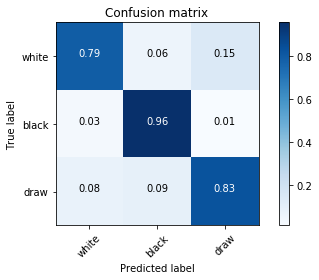

In [53]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cnf_matrix = confusion_matrix(test_ys, pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['white', 'black', 'draw'], normalize=True)

In [54]:
print(pred.tolist().count('0\n'), pred.tolist().count('1\n'), pred.tolist().count('2\n'))
print(test_ys.tolist().count('0\n'), test_ys.tolist().count('1\n'), test_ys.tolist().count('2\n'))

1274 1219 1311
1440 1054 1310


In [55]:
clf.feature_importances_

array([0.00612645, 0.005769  , 0.00746755, 0.00715184, 0.00824136,
       0.01178452, 0.00822961, 0.00660453, 0.00948535, 0.01257757,
       0.00896756, 0.00987273, 0.01216293, 0.01430373, 0.01482138,
       0.01058148, 0.00921002, 0.0101941 , 0.01176704, 0.0121737 ,
       0.01413567, 0.01451436, 0.01214963, 0.01192529, 0.01107174,
       0.01052104, 0.01158245, 0.01379139, 0.01366072, 0.01171096,
       0.01393145, 0.01057307, 0.01006842, 0.01022003, 0.01143888,
       0.01217052, 0.01556694, 0.01181408, 0.01022694, 0.01172998,
       0.00982466, 0.01071498, 0.01097803, 0.00953273, 0.01313679,
       0.01201911, 0.01269691, 0.01304768, 0.01013806, 0.01039868,
       0.00992592, 0.00847552, 0.01043725, 0.01392408, 0.01340536,
       0.01151968, 0.00575734, 0.00494149, 0.00640433, 0.00691763,
       0.00611689, 0.00972913, 0.00988242, 0.00631869, 0.00842787,
       0.00929461, 0.01398295, 0.01396684, 0.01951581, 0.02081928,
       0.03949018, 0.03761502, 0.15025752, 0.00464715, 0.00544

***Try Gradient Boosters (Best Accuracy: 72%)***

In [36]:
clf2 = GradientBoostingClassifier(n_estimators = 1000, max_depth = 2)
clf2.fit(train_xs, train_ys)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [37]:
pred2 = clf2.predict(test_xs)
total = test_ys.shape[0]
correct = len([x for x in pred2==test_ys if x==True])
print("Out of a total of %d samples, %d were correct" %(total, correct))

Out of a total of 3804 samples, 2731 were correct


In [38]:
print(pred2.tolist().count('0\n'), pred2.tolist().count('1\n'), pred2.tolist().count('2\n')) #white wins, black wins, draws

1280 1201 1323


In [39]:
clf2.feature_importances_

array([0.00529058, 0.00715654, 0.00898489, 0.00766315, 0.0143531 ,
       0.01992816, 0.00498996, 0.00842897, 0.00607728, 0.01137959,
       0.00779629, 0.0080015 , 0.00977079, 0.00760798, 0.01096505,
       0.00371708, 0.00465379, 0.00555733, 0.00545691, 0.00776679,
       0.0090962 , 0.01361296, 0.00605664, 0.01108283, 0.00919246,
       0.01004243, 0.00783399, 0.00646281, 0.00458865, 0.00298403,
       0.00966631, 0.00723457, 0.00556381, 0.00578448, 0.00787219,
       0.00499614, 0.01139018, 0.00332243, 0.00602629, 0.0072007 ,
       0.01150191, 0.00541667, 0.00747311, 0.00714779, 0.01285403,
       0.00709692, 0.00601588, 0.01128356, 0.00642001, 0.00695934,
       0.01002372, 0.00915949, 0.01398047, 0.01035573, 0.00618836,
       0.00881227, 0.00378904, 0.00326467, 0.00555569, 0.00641957,
       0.00319319, 0.00883808, 0.01099997, 0.0076455 , 0.00179582,
       0.01446413, 0.01255089, 0.00886381, 0.00917219, 0.01430635,
       0.04454019, 0.0384387 , 0.33371993, 0.00587243, 0.01032

In [56]:
def predict_result(fen, classifier = clf):
    global les
    
    line_features = []
    position = fen[:fen.index(' ')]
    
    #Split the position into individual squares
    rows = position.split('/')
    expanded_position = []
    for row in rows:
        expanded_row = ''
        for char in row:
            if char.isdigit():
                for i in range(int(char)):
                    expanded_row += ' '
            else:
                expanded_row += char
        expanded_row = [char for char in expanded_row]
        expanded_position += expanded_row
    line_features += expanded_position
    
    #Count number of each type of piece
    qs = position.count('q')
    Qs = position.count('Q')
    rs = position.count('r')
    Rs = position.count('R')
    pieces = position.count('b')+position.count('n')
    Pieces = position.count('B')+position.count('N')
    pawns = position.count('p')
    Pawns = position.count('P')
    developed_pawns = expanded_position[48:].count('p')
    Developed_Pawns = expanded_position[:16].count('P')
    
    line_features.append(qs)
    line_features.append(Qs)
    line_features.append(rs)
    line_features.append(Rs)
    line_features.append(pieces)
    line_features.append(Pieces)
    line_features.append(pawns)
    line_features.append(Pawns)
    line_features.append(9*(Qs-qs)+5*(Rs-rs)+3*(Pieces-pieces)+(Pawns-pawns)) #material advantage
    line_features.append(developed_pawns)
    line_features.append(Developed_Pawns)
    
    #Convert to numeric
    transformed = []
    for i in range(64):
        transformed.append(les[i].transform([line_features[i]]))
    transformed += line_features[64:]
    transformed = np.array(transformed)
    transformed = transformed.reshape(1, -1)
    
    #Predict
    pred = classifier.predict(transformed)
    
    #Print prediction
    if pred == '0\n':
        print("White is predicted to win")
    elif pred == '1\n':
        print("Black is predicted to win")
    else:
        print("The predicted result is a draw")
    
    #get "score" (expected points earned by white where win = 1 point and draw = 0.5 points)
    probabilities = classifier.predict_proba(transformed)
    score = probabilities[0][0] + 0.5*probabilities[0][2]
    print("Score: ", score) #a score of > 0.5 favours white. < 0.5 favours black


In [86]:
predict_result("4b3/8/2P5/N7/3p1p2/3Pk3/pK6/8 b - - 0 70")

Black is predicted to win
Score:  0.23
